In [165]:
import sys, os
import numpy as np
import h5py
import math
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm
from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Cropping2D, Concatenate, Input, MaxPooling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMakerCVAE import *

In [2]:
LATENT_DIM = 128
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 512
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-3

In [3]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-12-04 12:45:32.550011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 12:45:32.629071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 12:45:32.629320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
args_gen = {'X_key' : 'image',
    'y_key' : 'specz_redshift',
    'scaler' : False,
    'labels_encoding' : False,
    'batch_size': BATCH_SIZE,
    'mode' : 'train',
    'shuffle' : False}

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation.hdf5', **args_gen)

In [5]:
# Prior
prior = tfd.Independent(tfd.Normal(loc = tf.zeros(LATENT_DIM), scale = 1.0), reinterpreted_batch_ndims = 1)

# Encoder
images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = (1,))
conv1 = Conv2D(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(64, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(conv1)
conv3 = Conv2D(128, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(conv2)
flatten1 = Flatten()(conv1)
flatten2 = Flatten()(conv2)
flatten3 = Flatten()(conv3)
x = tf.keras.layers.Concatenate()([flatten1, flatten2, flatten3, redshifts])
x = Dense(256, activation = "relu")(x)
x = Dense(256, activation = "relu")(x)
x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(x)
z = tfpl.MultivariateNormalTriL(LATENT_DIM, activity_regularizer = tfpl.KLDivergenceRegularizer(prior, weight=KL_WEIGHT))(x)

encoder = Model([images, redshifts], z)

In [6]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 64)   1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 32, 32)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 32, 32)  32896       ['conv2d_1[0][0]']           

In [7]:
zc = Input(shape = (LATENT_DIM + 1,))
x = Dense(256, activation = "relu")(zc)
x = Dense(256, activation = "relu")(x)
x = Dense(128 * 32 * 32 + 64 * 32 * 32 + 32 * 64 * 64, activation = "relu")(x)
dense1, dense2, dense3 = tf.split(x, [128 * 32 * 32, 64 * 32 * 32, 32 * 64 * 64], axis = 1)
reshape1 = Reshape((128, 32, 32))(dense1)
reshape2 = Reshape((64, 32, 32))(dense2)
reshape3 = Reshape((32, 64, 64))(dense3)
deconv1 = Conv2DTranspose(64, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape1)
deconv2 = Conv2DTranspose(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape2 + deconv1)
deconv3 = Conv2DTranspose(5, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape3 + deconv2)
cropping = Cropping2D(cropping = ((0, 1), (0, 1)), data_format = 'channels_first')(deconv3)

outputs = Reshape(IMAGE_SHAPE)(cropping)

decoder = Model(zc, outputs)

In [8]:
z = encoder([images, redshifts])
zc = tf.keras.layers.Concatenate()([z, redshifts])  # Assuming you want to concat the output of encoder and redshifts
decoder_output = decoder(zc)

model = Model(inputs = [images, redshifts], outputs = decoder_output)

In [9]:
encoder.summary()
decoder.summary()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 64)   1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 32, 32)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 32, 32)  32896       ['conv2d_1[0][0]']           

In [10]:
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss = 'mse')

In [59]:
run = neptune.init_run(
    name = "CVAE",
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

model_name = 'cvae_127_175'

weights_path = os.path.join('/data3/Billy/models/', model_name) + '/weights'

neptune_callback = NeptuneCallback(run = run)

LR_callback = ReduceLROnPlateau()

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-254


In [46]:
history = model.fit(train_gen, epochs = 25, callbacks = [neptune_callback, LR_callback], validation_data = val_gen, verbose = 1)

Epoch 1/25


2023-11-27 00:24:30.965257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


400/400 [==============================] - ETA: 0s - loss: 0.8556

2023-11-27 00:35:59.944389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


400/400 [==============================] - 835s 2s/step - loss: 0.8556 - val_loss: 1.2529 - lr: 1.0000e-07
Epoch 2/25
400/400 [==============================] - 870s 2s/step - loss: 0.8556 - val_loss: 1.2518 - lr: 1.0000e-07
Epoch 3/25
400/400 [==============================] - 852s 2s/step - loss: 0.8554 - val_loss: 1.2538 - lr: 1.0000e-07
Epoch 4/25
400/400 [==============================] - 857s 2s/step - loss: 0.8556 - val_loss: 1.2510 - lr: 1.0000e-07
Epoch 5/25
400/400 [==============================] - 847s 2s/step - loss: 0.8557 - val_loss: 1.2510 - lr: 1.0000e-07
Epoch 6/25
400/400 [==============================] - 854s 2s/step - loss: 0.8556 - val_loss: 1.2513 - lr: 1.0000e-07
Epoch 7/25
400/400 [==============================] - 857s 2s/step - loss: 0.8558 - val_loss: 1.2487 - lr: 1.0000e-07
Epoch 8/25
400/400 [==============================] - 877s 2s/step - loss: 0.8555 - val_loss: 1.2532 - lr: 1.0000e-07
Epoch 9/25
400/400 [==============================] - 846s 2s/step 

In [65]:
model.save_weights(weights_path)

In [60]:
model.load_weights(weights_path)

2023-12-04 12:52:52.258695: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 335545344 exceeds 10% of free system memory.
2023-12-04 12:52:52.258738: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 335544320 exceeds 10% of free system memory.


z = 0.0843899995


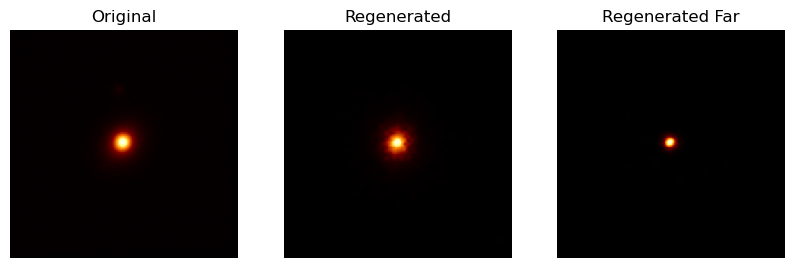

In [87]:
lib = 3
index = 466
z = test_gen[lib][0][1][index]
z_shifted = 2
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Far")
plt.show()

In [161]:
def stdev(data):
    """Calculate standard deviation, handling cases with insufficient data."""
    n = len(data)
    if n < 2:
        return 0
    mean = sum(data) / n
    variance = sum((x - mean) ** 2 for x in data) / (n - 1)
    return math.sqrt(variance)

In [163]:
count_lo = 0
total_lo = [0, 0, 0, 0, 0]
values_for_std_dev = [[], [], [], [], []]  # List of lists to store values for each band

for i in range(len(test_gen)):
    for j in range(len(test_gen[0][0][1])):
        if test_gen[i][0][1][j] <= 0.1:
            count_lo += 1
            print(count_lo)

            for band in range(5):
                value = test_gen[i][0][0][j][band][63, 63]
                total_lo[band] += value
                values_for_std_dev[band].append(value)

            # Break if we have 10 values
            if count_lo == 10:
                break
    if count_lo == 10:
        break

# Calculating the mean and standard deviation for each band
means_lo = [sum(values)/len(values) if values else 0 for values in values_for_std_dev]
std_devs_lo = [stdev(values) if len(values) > 1 else 0 for values in values_for_std_dev]

1
2
3
4
5
6
7
8
9
10


NameError: name 'math' is not defined

In [167]:
count_hi = 0
values_for_std_dev = [[], [], [], [], []]  # List of lists to store values for each band

for i in range(len(test_gen)):
    for j in range(len(test_gen[0][0][1])):
        if test_gen[i][0][1][j] >= 3:
            count_hi += 1
            print(count_hi)

            for band in range(5):
                value = test_gen[i][0][0][j][band][63, 63]
                values_for_std_dev[band].append(value)

            # Break if we have 10 values
            if count_hi == 10:
                break
    if count_hi == 10:
        break

# Calculating the mean and standard deviation for each band
means_hi = [sum(values)/len(values) if values else 0 for values in values_for_std_dev]
std_devs_hi = [stdev(values) if len(values) > 1 else 0 for values in values_for_std_dev]

1
2
3
4
5
6
7
8
9
10


In [168]:
values_for_std_dev_lo = [[], [], [], [], []]
values_for_std_dev_hi = [[], [], [], [], []]

for i in range(0, 10):
    
    str = prior.sample(1)[0]
    strlo = np.concatenate((str, np.array([0.1])))
    strlo = strlo.reshape(1, LATENT_DIM + 1)
    strhi = np.concatenate((str, np.array([3])))
    strhi = strhi.reshape(1, LATENT_DIM + 1)
    
    for band in range(0, 5): 
        
        value_lo = decoder([strlo])[0][band][63, 63]
        value_hi = decoder([strhi])[0][band][63, 63]
        
        values_for_std_dev_lo[band].append(value_lo)
        values_for_std_dev_hi[band].append(value_hi)
        
means_lo_gen = [sum(values)/len(values) if values else 0 for values in values_for_std_dev_lo]
std_devs_lo_gen = [stdev(values) if len(values) > 1 else 0 for values in values_for_std_dev_lo]
means_hi_gen = [sum(values)/len(values) if values else 0 for values in values_for_std_dev_hi]
std_devs_hi_gen = [stdev(values) if len(values) > 1 else 0 for values in values_for_std_dev_hi]

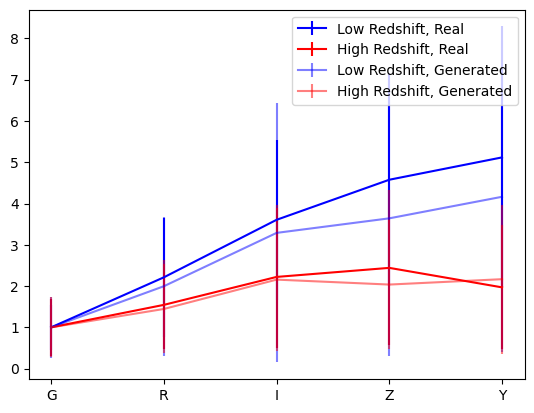

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-254/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-253/metadata


In [177]:
x = np.array([0, 1, 2, 3, 4])
bands = ['G', 'R', 'I', 'Z', 'Y']
plt.xticks(x, bands)

means_lo_normalized = [m / means_lo[0] for m in means_lo]
std_devs_lo_normalized = [std / means_lo[0] for std in std_devs_lo]
means_hi_normalized = [m / means_hi[0] for m in means_hi]
std_devs_hi_normalized = [std / means_hi[0] for std in std_devs_hi]
means_lo_gen_normalized = [m / means_lo_gen[0] for m in means_lo_gen]
std_devs_lo_gen_normalized = [std / means_lo_gen[0] for std in std_devs_lo_gen]
means_hi_gen_normalized = [m / means_hi_gen[0] for m in means_hi_gen]
std_devs_hi_gen_normalized = [std / means_hi_gen[0] for std in std_devs_hi_gen]

plt.errorbar(x, means_lo_normalized, yerr = std_devs_lo_normalized, c = 'blue', label = 'Low Redshift, Real')
plt.errorbar(x, means_hi_normalized, yerr = std_devs_hi_normalized, c = 'red', label = 'High Redshift, Real')
plt.errorbar(x, means_lo_gen_normalized, yerr = std_devs_lo_gen_normalized, c = 'blue', alpha = 0.5, label = 'Low Redshift, Generated')
plt.errorbar(x, means_hi_gen_normalized, yerr = std_devs_hi_gen_normalized, c = 'red', alpha = 0.5, label = 'High Redshift, Generated')
plt.legend()
plt.show()

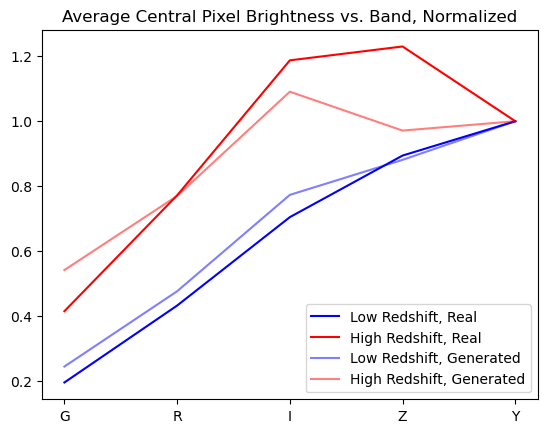

In [170]:
x = np.array([0, 1, 2, 3, 4])
bands = ['G', 'R', 'I', 'Z', 'Y']
plt.xticks(x, bands)
plt.plot(x, [x / total_lo[4] for x in total_lo], c = 'blue', label = 'Low Redshift, Real')
plt.plot(x, [x / total_hi[4] for x in total_hi], c = 'red', label = 'High Redshift, Real')
plt.plot(x, [x / total_lo_gen[4] for x in total_lo_gen], c = 'blue', alpha = 0.5, label = 'Low Redshift, Generated')
plt.plot(x, [x / total_hi_gen[4] for x in total_hi_gen], c = 'red', alpha = 0.5, label = 'High Redshift, Generated')
plt.legend()
plt.title('Average Central Pixel Brightness vs. Band, Normalized')
plt.show()

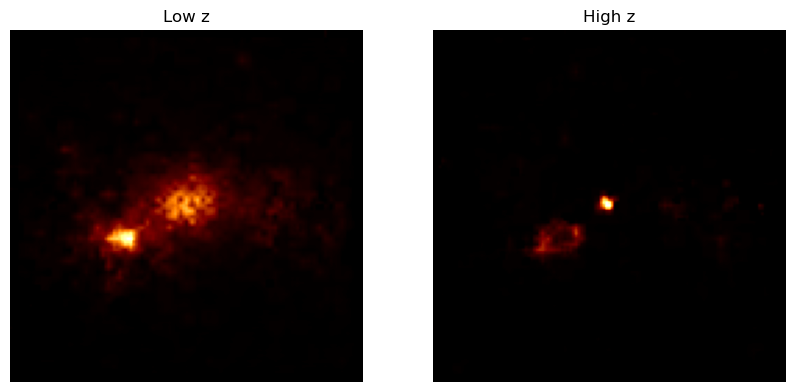

In [114]:
band = 0
str = prior.sample(1)[0]
strlo = np.concatenate((str, np.array([0.1])))
strlo = strlo.reshape(1, LATENT_DIM + 1)
strhi = np.concatenate((str, np.array([3.25])))
strhi = strhi.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(decoder([strlo])[0][band], cmap = 'afmhot')
axes[1].imshow(decoder([strhi])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title("Low z")
axes[1].set_title("High z")
plt.show()

In [66]:
hf = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_testing.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
output_image = decoder([str])[0]
image_g = output_image[0]
image_r = output_image[1]
image_i = output_image[2]
image_z = output_image[3]
image_y = output_image[4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(40913)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    output_image = decoder([str])[0]
    image_g = output_image[0]
    image_r = output_image[1]
    image_i = output_image[2]
    image_z = output_image[3]
    image_y = output_image[4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

100%|██████████| 40913/40913 [07:56<00:00, 85.79it/s]


In [67]:
hf = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_training.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
output_image = decoder([str])[0]
image_g = output_image[0]
image_r = output_image[1]
image_i = output_image[2]
image_z = output_image[3]
image_y = output_image[4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(204572)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    output_image = decoder([str])[0]
    image_g = output_image[0]
    image_r = output_image[1]
    image_i = output_image[2]
    image_z = output_image[3]
    image_y = output_image[4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

100%|██████████| 204572/204572 [40:54<00:00, 83.34it/s]


In [68]:
hf = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_validation.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
output_image = decoder([str])[0]
image_g = output_image[0]
image_r = output_image[1]
image_i = output_image[2]
image_z = output_image[3]
image_y = output_image[4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(40913)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    output_image = decoder([str])[0]
    image_g = output_image[0]
    image_r = output_image[1]
    image_i = output_image[2]
    image_z = output_image[3]
    image_y = output_image[4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

100%|██████████| 40913/40913 [08:21<00:00, 81.58it/s]


Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-244/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-243/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-242/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-241/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.a

In [ ]:
# END